#### Example: Information geometry informs data size requirements 

We've made great progress in large models by increasing sample size $n$ via advances in data collection and computation. 
The goal is to get our estimate $\hat \theta$ as close to truth $\theta_0$ as possible. 
Asymptotically, maximum likelihood estimates (MLEs) will yield variance of $\mathcal{I}_{\theta_0}/n$, 
which describes how close $\hat \theta$ is to $\theta_0$. 
Thus, our journey toward powerful large models is essentially one of shrinking $\mathcal{I}_{\theta_0}/n$.
We control $n$, so it makes sense that we started there. 
We don't control $\mathcal{I}_{\theta_0}$, but we should take advantage of its structure. 

$\mathcal{I}_{\theta_0}$ is a Riemann metric, so may have high-magnitude tangent-space dimensions thereby bestowing significant information or mutual information. 
In turn, this information makes our estimator variance $\mathcal{I}_{\theta_0}/n$ smaller. 
If we discover high-information dimensions, we may over-weight them to have the same result as increasing $n$, at least for target dimensions. 
So, we'll replace the usual regularizing scalar $\lambda$ with a function to and from information matrices. 

The following example illustrates these mechanisms in play, aiding estimation.

$\hat \theta_A := \arg \max_{\theta \in \Theta} \log f_X(X_B; \theta) - n_A (\theta - \hat \theta_A)^T \lambda \left( \hat{\mathcal{I}}_{X_A} \right) (\theta - \hat \theta_A)$.

$\hat \theta_B := \arg \max_{\theta \in \Theta} \log f_X(X_A; \theta) $.

$\hat{\mathcal{I}}_{X_A} := n_A^{-1} \sum_{i=1}^{n_A} \left( \nabla_\theta \log f_X(X_A; \theta) \right) \left( \nabla_\theta \log f_X(X_A; \theta) \right)^T $
$ \to_{a.s.} \mathcal{I}_{\theta_0} \text{ as } n \to \infty$

$\theta = (\mu_1, \mu_2, \rho, \sigma, \tau)^T \in \Theta \subset \mathbb{R}^p, \; p = 5 $.

$\eta = (\mu, \mu, \rho, \sigma, \tau)^T \in H \subset \Theta$, where $H$ is the submanifold where $\mu = \mu_1 = \mu_2$. 

$\theta_0 = (\mu_0, \mu_0, \rho_0, \sigma_0, \tau_0)^T \in H \text{ and } X \sim N_2\left( \begin{bmatrix} \mu_0 \\ \mu_0 \end{bmatrix}, \begin{bmatrix} \sigma_0^2 & \sigma_0 \tau_0 \rho_0 \\ \sigma_0 \tau_0 \rho_0 & \tau_0^2 \end{bmatrix} \right)$

$\lambda : P \to P$ where $P \subset \mathbb{R}^{p \times p}$ is a set of positive semi-definite (PSD) matrices.

In [94]:
## foundational definitions 
import numpy as np 
from scipy.stats import multivariate_normal
from scipy.special import expit, logit
from scipy.optimize import minimize 
from numpy.linalg import inv 

def sample_data(n, mu0=0., rho0=0., sigma0=1., tau0=1.): 
    'generates sample matrix x' 
    mean = np.array([mu0, mu0]) 
    cov = np.array([[sigma0*sigma0, sigma0*tau0*rho0], [sigma0*tau0*rho0, tau0*tau0]]) 
    return multivariate_normal.rvs(mean=mean, cov=cov, size=n) 

def unpack_theta(theta): 
    'unpack from (mu1, mu2, logit rho, log sigma, log tau)'
    mu1 = theta[0] 
    mu2 = theta[1] 
    rho = expit(theta[2]) 
    sigma = np.exp(theta[3]) 
    tau = np.exp(theta[4]) 
    theta_vec = np.array([mu1, mu2, rho, sigma, tau]) 
    mean = np.array([mu1, mu2]) 
    cov = np.array([[sigma*sigma, sigma*tau*rho], [sigma*tau*rho, tau*tau]]) 
    return theta_vec, mean, cov 

def mle(x): 
    'x is a sampled matrix'
    def loss(theta): 
        _, mean, cov = unpack_theta(theta) 
        l = multivariate_normal.logpdf(x=x, mean=mean, cov=cov) 
        l = sum(l) 
        return -l  
    theta0 = [0., 0., 0., 0., 0.] 
    result = minimize(loss, theta0)  
    theta_A_estimate = result.x 
    info_estimate = inv(result.hess_inv) 
    return theta_A_estimate, info_estimate  

def memory_mle(x, info, theta_A): 
    '''
    info is an information matrix, already adjusted by regularizer and sample size 
    theta_A is the memorized estimate
    '''
    def loss(theta): 
        theta_vec, mean, cov = unpack_theta(theta) 
        memory_term = np.transpose(theta_vec - theta_A) 
        memory_term = np.matmul(memory_term, info) 
        memory_term = np.matmul(memory_term, theta_vec - theta_A) 
        l = multivariate_normal.logpdf(x=x, mean=mean, cov=cov) 
        l = sum(l) 
        l = l - memory_term 
        return -l 
    theta0 = [0., 0., 0., 0., 0.] 
    return minimize(loss, theta0).x 

print('Examples...') 
n_A = 10 
n_B = 10 
x = sample_data(n_A) 
y = sample_data(n_B) 
print(f'sample_data({n_A})[:3,]: {x[:3,]}') 
theta_A_estimate, info_estimate = mle(x) 
print(f'initial estimate: {unpack_theta(theta_A_estimate)[0]}') 
print(f'info estimate: {info_estimate}')
theta_B_estimate = memory_mle(y, info_estimate, theta_A_estimate) 
print(f'updated estimate: {theta_B_estimate}') 

Examples...
sample_data(10)[:3,]: [[-0.63383035 -1.31419678]
 [ 0.04025527  1.01620383]
 [-0.26725872  0.02448196]]
initial estimate: [-0.48245104 -0.06806565  0.29299423  0.42164847  0.75460873]
info estimate: [[ 6.17050422e+01 -1.17109593e+01  1.86733519e-01 -2.47740511e-01
  -5.57971422e-01]
 [-1.17109593e+01  1.87966585e+01  1.68530502e-02 -3.75785191e-01
  -1.44981030e-02]
 [ 1.86733519e-01  1.68530502e-02  5.52158324e-01 -5.99420353e-01
  -6.34738564e-01]
 [-2.47740511e-01 -3.75785191e-01 -5.99420353e-01  2.05791116e+01
  -9.54750912e-01]
 [-5.57971422e-01 -1.44981030e-02 -6.34738564e-01 -9.54750912e-01
   2.06599707e+01]]
updated estimate: [-3.23832916e-01 -5.34646660e-04 -1.67218057e+01 -5.25297735e-01
 -4.37809893e-01]


When $\sigma = \tau = 1$, $\mu$'s information is $2(1-\rho)/(1 - \rho^2)$. This illustrates the effect of high-information dimensions. 
- As $\rho \to -1$, information becomes infinite, so a single sample reveals $\mu_0$ exactly via $\hat \mu_0 = (X_1 + X_2)/2$. 
- If $\rho = 0$, information is 2, so we need only half the sample size. 
- As $\rho \to 1$, information becomes 1, so multidimensionality lends no benefit. 

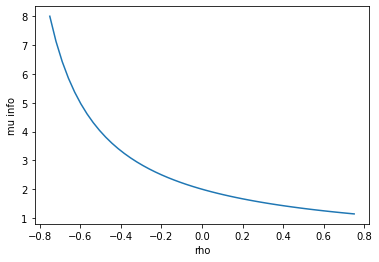

In [96]:
## plot of mu's info 
import matplotlib.pyplot as plt

rho_val_list = np.linspace(-.75, .75).tolist() 
info = lambda rho : 2.*(1. - rho)/(1. - rho*rho) 
info_val_list = [info(rho) for rho in rho_val_list] 

plt.plot(rho_val_list, info_val_list)
plt.ylabel('mu info')
plt.xlabel('rho')
plt.show()

For $\rho \approx -1$, we'll benefit from overweighting our information matrix estimate. 

In [99]:
def get_error(n_A, n_B, rho0, lmbda): 
    x = sample_data(n_A, rho0=rho0) 
    y = sample_data(n_B, rho0=rho0) 
    theta_A_estimate, info_estimate = mle(x) 
    theta_B_estimate = memory_mle(y, n_A*lmbda*info_estimate, theta_A_estimate) 
    return theta_B_estimate[0] 

get_error(10, 10, rho0=-.99, lmbda=1)
lmbda_list = np.linspace(0.1)

-0.07446399707385237

THE FOLLOWING IS OLD CONTENT TO BE REVISED

# memory as geometry 

Under asymptotic analysis and mild regularity assumptions, all statistical models have a Lagrangian-form regularizer equivalent to memory \[1\]. 
We will mathematically generalize this concept to show a breadth of geometries equivalent to memory. 
As a corollary, we'll construct universal sufficient statistics. 
Finally, given large models' recent immense productivity, it is natural to expect hardware limitations to soon motivate miniaturization (TODO CITE). 
We'll leverage memory's geometric properties to construct miniaturization techniques for deep learning, including 
memory merges, regularizers as memory, and a _frontal lobe_ concept. 

## result: Langrangian-regularized estimates are MLEs 

The MLE's powerful theoretical guarantees provide an important foundation for Deep Learning's success. 
So, we should be curious as to when our new estimation paradigms are equivalent to MLEs. 
Theory is a guide to the statistical researcher. 

**LEMMA 1:** 

Let the following solution exist uniquely. 

$$ \hat \theta_L = \arg \max_{\theta \in \Theta} n^{-1} \log f_X(X;\theta) - \lambda g(\theta) $$

Then then there exists linear subspace $H \subset \Theta$ 
such that $\hat \theta_L$ is the solution to the following optimization program. 

$$ \hat \theta_L = \arg \max_{\theta \in H} \log f_X(X; \theta) $$

**PROOF:** 

Define $\hat{\mathcal{L}} := n^{-1} \log f_X(X;\theta) - \lambda g(\theta)$. 
Since $\hat \theta_L = \arg \max_{\theta \in \Theta} \hat{\mathcal{L}}$ exists uniquely, 
and $\log f_X, g$ are differentiable, so we are guaranteed that 

1. $\nabla_\theta \hat{\mathcal{L}} = 0$ and 
2. $\nabla_\lambda \hat{\mathcal{L}} = 0$. 

There exists $c = g(\hat \theta_L)$ 
and $\mathcal{L} := n^{-1} \log f_X(X;\theta) - \lambda( g(\theta) - c )$ such that 

3. $\nabla_\theta \hat{\mathcal{L}} = \nabla_\theta \mathcal{L} = 0$ and 
4. $\nabla_\lambda \mathcal{L} = c$. 

By (4), $\theta \in g^{-1}(c)$. 
For $\theta$ sufficiently near $\hat \theta_L$, $g^{-1}(\theta) \approx \left( J_{g, \hat \theta_L} \right)^{-1} \left(\theta - \hat \theta_L \right)$ by the inverse function theorem (TODO: check calcs, and use Constant Rank Theorem instead). 
Define this local linear subspace as $H := \left\{ \theta \; : \; \eta \; s.t. \; \exists \theta \; \& \; \eta = \left( J_{g, \hat \theta_L} \right)^{-1} \left(\theta - \hat \theta_L \right) \right\}$ or $H$-space. 

Since $\nabla_\theta \hat{\mathcal{L}} = 0$ also holds, 
$\mathcal{L}$ is a Langrangian constraining $\theta$ to linear subspace $H \subset \Theta$. 

$\square$

**RESULT 1:** 

If $\hat \theta_{MLE}:= \arg\max_{\theta \in \Theta} \log f_X(X;\theta) $, 
then $\hat \theta_L$ is an MLE. 

**PROOF:** 

Since $\hat \theta_{MLE}$ is an MLE, $f_X$ is a likelihood function. 
By LEMMA 1, the estimation program is constrained to well-defined linear subspace $H \subset \Theta$. 
Hence $\hat \theta_L$ is indeed an MLE. 

$\square$ 

TODO: Clarify $J$. 

**COROLLARY 1:** 

Define $J := \left[ \partial \theta_0 / \partial \eta_j \right]$, 
$J^+$ to be the pseudo-inverse matrix, 
and $\mathcal{I}_H :=  J^+ \mathcal{I}_{\theta_0} J^{+T}$

If $X_i \sim  f_X(x; \theta_0)$ and $\hat \theta_L$ is sufficiently near $\hat \theta_{MLE}$ and $n$ sufficiently large, 
then $\hat \theta_L$ has a corresponding estimate $\hat \eta$ in the $H$-space basis,  
and $\sqrt{n} \left( \hat \eta - J^+ \theta_0 \right) \sim N(0, \mathcal{I}_H )$. 

**PROOF:** 

$0 = \nabla_\theta \log f_X(X; \theta) $

$\approx \nabla_\theta \log f_X(X; \theta_0) - \left( \theta - \theta_0 \right)^T \nabla_\theta^T \nabla_\theta \log f_X(X; \theta_0) $ by Taylor expansion 

$ \Rightarrow \sqrt{n}^{-1} \nabla_\theta \log f_X(X; \theta_0) \approx \frac{\sqrt{n}}{n} \left( \theta - \theta_0 \right)^T \nabla_\theta^T \nabla_\theta \log f_X(X; \theta_0) $

$ \Rightarrow N \mathcal{I}_{\theta_0}^{1/2} =_d \sqrt{n} \left( \theta - \theta_0 \right)^T \mathcal{I}_{\theta_0} $ 
where $=_d$ is equivalence in distribution and $N \sim N\left(0, I_{\dim(\Theta)} \right)$ 

Apply lemma 1 by parameterizing $H$-space via $\theta \gets J \eta$.

$ \Rightarrow \sqrt{n} \left( J \eta - \theta_0 \right) \sim N(0, \mathcal{I}_{\theta_0}) $

$ \Rightarrow \sqrt{n} \left( \eta - J^+ \theta_0 \right) \sim N(0, J^+ \mathcal{I}_{\theta_0} J^{+T} ) $ 

$\square$ 

Since $J^+$ is also a projection matrix, the distribution of $\hat \eta$ is equivalent to the $\hat \theta_{MLE}$ projection, 
$\sqrt{n} J^+ \left( \hat \theta_{MLE} - \theta_0 \right) \sim N(0, \mathcal{I}_H )$. 

**COROLLARY 2:** 

$\text{rank}(J^+) > 0 \Rightarrow \mathcal{I}_H < \mathcal{I}_{\theta_0}$ 

**PROOF:** 

Since $\mathcal{I}_{\theta_0} > 0$ (positive semi-definite), there is matrix $A$ such that $\mathcal{I}_{\theta_0} = AA^T $. 
Since $J^+$ is a projection matrix, we have the following.

$ \mathcal{I}_{\theta_0} = \mathcal{I}_H + (I - J^+)AA^TJ^{+T} + J^+AA^T(I - J^+)^T + (I - J^+)AA^T(I - J^+)^T$ 

$ = \mathcal{I}_H + 0 + 0 + (I - J^+)AA^T(I - J^+)^T $ by linear independence of complementrary projections 

Recognizing $(I - J^+)AA^T(I - J^+)^T > 0$ completes the proof. 

$\square$ 

If $\hat \theta_L \not= \hat \theta_{MLE}$ for all $n$, then $\theta_0 \not \in H$, 
and we may interpret $H$ as the tangent space of a biased sub-manifold in $\Theta$. 
However, since dimensional reductions cause $\mathcal{I}_H < \mathcal{I}_{\theta_0}$, 
a sufficiently-unbiased manifold produces more-efficient estimators, 
particularly so if $\theta_0 \in \lim_{n \to \infty} H$. 

## result: elliptical sub-manifolds in $\Theta$-space are memories

Define a _memory_ as all information associated with samples $X_1, X_2, \ldots, X_n$ under a model. 
Concretely, we'll use approximate MLE sufficient statistics $\left( \hat \theta, \hat{\mathcal{I}} \right)$.

WLOG, assume $\mathcal{I}_{\theta_0} > 0$. 
If not, perfect correlations exist, so the model can be reparameterized to a lower dimension. 
$\mathcal{I}_{\theta_0} > 0 \Rightarrow \mathcal{I}_{\theta_0} = AA^T \; \& \; \exists A^{-1}$. 
For all $B \in \mathbb{R}^{p \times q}$ where $p = \dim(\Theta)$ and $q \leq p$, 
there exists $J = A^{-1}B$ mapping from an unbiased, linear $H$-space to $\Theta$-space, 
and $(\theta - \theta_0)^T AA^T (\theta - \theta_0) = (\eta - \eta_0)^T J^T AA^T J (\eta - \eta_0) = (\eta - \eta_0)^T BB^T (\eta - \eta_0)^T$.
This is true for any choice of $B$, so covers all PSD matrices $BB^T \geq 0$. 

Choosing $g(\theta) = (\theta - \theta_0)^T BB^T (\theta - \theta_0)$ and applying lemma 1, 
we recognize the existence of a elliptical sub-manifold in $\Theta$-space corresponding to Lagrangian-form regularizer $g(\theta)$. 
Hence, there exists an MLE with $\mathcal{I} = BB^T$ when estimation is constrained to a subspace with $J = A^{-1}B$. 
So, for every elliptical sub-manifold with Riemann metric $\mathcal{I} = BB$, there exists another linear sub-manifold $H$ 
such that $\arg\max_{\theta \in H} \log f_X(X;\theta)$ has approximate sufficient statistics $(\hat \theta, BB^T)$. 

Since we interpret $(\hat \theta, BB^T)$ as a memory, 
every elliptical sub-manifold $(\eta - \eta_0)^T BB^T (\eta - \eta_0)^T$ 
has an associated memory. 

TODO: look for a 1-1 correspondence, tying each manifold to a unique memory. 
Example consideration: $(\hat \eta, BB^T)$ and $(\eta - \hat \eta)^T BB^T (\eta - \hat \eta)^T$. 

## likely decent definition for memory 

$(\theta_H, H)$ for $\theta_H \in \Theta \subset \mathbb{R}^p$ and smooth, $q$-dimensional sub-manifold $H \subset \Theta$
 with local tangent space $T_{\theta_H}$ and associated total derivative $D_{\theta_H} \in \mathbb{R}^{p \times q}$, 
 so that $\hat \theta_H = \arg \max_{\theta \in H} \log f(X; \theta) \; \& \; X \sim f(X; \theta_H)$, 
 and $\mathcal{I}_{\theta_H} = D_{\theta_H}D_{\theta_H}^T$. 

 This $(\theta_H, H)$ definition works, because it allows me to sneak-in other kinds of subspaces via Lagrangian constraints like "$-\lambda \|\hat{\mathcal{I}}_\theta \|$".

## frontal lobe 

In humans, the frontal lobe operates on a longer-term timeline than Hippocampus-based short-term memory, 
but on a shorter horizon than remaining cortical regions, 
so functions as a mid-term horizon or _working space_ (TODO: CITE!). 
Observing miniaturization requirements on deep learning imposes parameter space restrictions, 
which deny infinite growth strategies like `net2net` (TODO: CITE!). 
Instead, we'll allocate dimensional parameter space to a flex capacity, 
so operating in similar capacity to a biological frontal lobe. 
Mathematically, we'll achieve this by all filling dimensional space with information, 
then periodically reducing information stored in the frontal lobe parameters. 
The net result is a temporary increase in dimensional space available to the model, 
which routinely moves information into long-term memory. 
This results in the following two-step optimization procedure.

1. $ \hat \theta = \arg \max_\theta \log f_X(X; \theta) $
$ - n_A (\theta - \hat \theta_A)^T \hat{\mathcal{I}}_{\hat \theta_A} (\theta - \hat \theta_A) $
2. $ \hat \theta = \arg \max_\theta  \log f_X(X; \theta) $ 
$ - n_A (\theta - \hat \theta_A)^T \hat{\mathcal{I}}_{\hat \theta_A} (\theta - \hat \theta_A) $ 
$ - \lambda \| \hat{\mathcal{I}}_\theta \|_{FL} $

Where $X$ has $n_B$ samples observed, and $\hat \theta_A$ was produced by memorizing $n_A$ samples. 

As we'll illustrate (TODO!), a frontal lobe is practically motivated in deep learning, 
because freezing all parameters in memory effectively consumes all dimensional space. 
By regularly relieving dimensional space, a necessary working space can be retained. 

Experimental design scratch: Repetitively add memorization tasks (ex. introducing more MNIST digits). 
- Control 1: No memorization. Expectation: catastrophic forgetting. 
- Control 2: Memorize, but do not include frontal lobe clearing. Expectation: limited memorization capacities in later iterations. 
- Experimental 1: Memorize with frontal lobe clearing. Expectation: improved memorization iterations. 
- Experimental X: Adjust Krylov dimension and frontal lobe hyper-parameter. 
  - Expectation 1: Higher Krylov dimensions increase memory space, but cost memory and computation. 
  - Expectation 2: $n_A$ may be a natural parameter for the frontal lobe. 

## references 

\[1\] Kirkpatrick et al. (2017) "Overcoming catastrophic forgetting in neural networks", PNAS